In [ ]:
import numpy as np
import pandas as pd
import scipy
import scipy.signal
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import skimage.measure
from PIL import Image

import random

In [ ]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def derivative_sigmoid(x):
    return (1 - sigmoid(x)) * sigmoid(x)

def relu(x):
    return x * (1 + np.sign(x)) / 2

def derivative_relu(x):
    return (1 + np.sign(x)) / 2

def leaky_relu(x):
    return x * ((1 + np.sign(x)) / 2 + 0.2 * (1 + np.sign(-x)) / 2)

def derivative_leaky_relu(x):
    return ((1 + np.sign(x)) / 2 + 0.2 * (1 + np.sign(-x)) / 2)

def tanh(x):
    return (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)

def derivative_tanh(x):
    return 1 - tanh(x)


def cross_entropy_loss(predicted, true):
    true = np.int_(np.arange(0, 10) == true)
    return -1 * np.sum(true * np.log(predicted), axis=1)

def cross_entropy_loss_derivative(predicted, true):
    true = np.int_(np.arange(0, 10) == true)
    return predicted - true


def softmax(z):
    if z.ndim == 1:
        return np.exp(z) / np.sum(np.exp(z))
    else:
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1, 1)

In [ ]:
def accuracy(true, pred):
    true = true.argmax(axis=1)
    pred = pred.argmax(axis=1)
    return (true == pred).sum() / len(pred)

In [ ]:
class DataBatcher():

    def __init__(self, data, batch_size = 64, shuffle = True):
        self.data = data
        self.index = 0
        self.items = []

        self.max = data.shape[0] // batch_size + (1 if data.shape[0] % batch_size != 0 else 0)

        if shuffle == True:
                self.data = np.random.permutation(self.data)

        for _ in range(self.max):
            self.items.append(self.data[batch_size * _: batch_size * (_ + 1)])

    def __iter__(self):
        return self

    def __next__(self):
        if self.index < self.max:
            value = self.items[self.index]
            self.index += 1
            return value[:, 1:], value[:, 0].reshape(-1,1)
        else:
            self.index = 0
            raise StopIteration

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Digit Recognizer/train.csv/train.csv')
data = np.array(data)
data = data.astype(float)

test_data = data[0:1000]
train_data = data[1000: 42000]


test_data[:, 1:] = test_data[:, 1:] / 255
train_data[:, 1:] = train_data[:, 1:] / 255


test_batches = DataBatcher(test_data, 64, True)
train_batches = DataBatcher(train_data, 64, True)

In [ ]:
class NaNException(Exception):
    "Training process failed, please decrease alpha parameter!"
    pass

class FullConnectedNeuralNetwork():

    @staticmethod
    def leaky_relu(x):
        return x * ( (1 + np.sign(x)) / 2 + 0.2 * (1 + np.sign(-x)) / 2 )

    @staticmethod
    def derivative_leaky_relu(x):
        return ( (1 + np.sign(x)) / 2 + 0.2 * (1 + np.sign(-x)) / 2 )

    @staticmethod
    def relu(x):
        return x * (1 + np.sign(x)) / 2

    @staticmethod
    def derivative_relu(x):
        return (1 + np.sign(x)) / 2

    @staticmethod
    def cross_entropy_loss(predicted, true):

        true = np.int_(np.arange(0,10) == true)

        return -1 * np.sum(true * np.log(predicted), axis = 1)

    @staticmethod
    def cross_entropy_loss_derivative(predicted, true):
        true = np.int_(np.arange(0,10) == true)

        return predicted - true

    @staticmethod
    def softmax(z):
        if z.ndim == 1:
            return np.exp(z) / np.sum(np.exp(z))
        else:
            return np.exp(z) / np.sum(np.exp(z), axis = 1).reshape(-1,1)


    def gradient_descent(self, loss, alpha):

        changes_w = []
        changes_b = []
        art = loss.copy()

        for i in range(len(self.neurons) + 1):
            if i == 0:
                art = (art @ (self.weights[-1 - i]).T)
            else:
                art = (art @ (self.weights[-1 - i]).T) * self.derivative(self.hidden_outputs_no_activation[-1 - i])

            changes_w.append(alpha * ((self.hidden_outputs_activation[-1 - i]).T @ art) / loss.shape[0])
            changes_b.append(alpha * (np.sum(art) / loss.shape[0]))

            if i == len(self.neurons):
                self.back_loss = (art @ self.weights[0].T)

        for i in range(len(changes_w)):
            self.weights[-2 - i] = self.weights[-2 - i] - changes_w[i]
            self.biases[-1 - i] = self.biases[-1 - i] - changes_b[i]



        try:
            if (np.isnan(self.weights[-2]).sum()) > 0:
                raise NaNException

            return self.back_loss

        except NaNException:
            print("Training process failed, please decrease alpha parameter!")
            raise NaNException

    def __init__(self, n_inputs, neurons, n_outputs,  purpose = 'classification', batches = False):

        self.neurons = neurons

        self.purpose = purpose

        self.n_inputs = n_inputs

        self.n_outputs = n_outputs

        self.trained  = False


    def prepare(self, gradient_method = 'gd', activation_func = 'sigmoid', seed = 42,loss_function = 'cross_entropy_loss', optimizer = False):

        np.random.seed(seed)


        if activation_func == 'sigmoid':
            self.activation_func = FullConnectedNeuralNetwork.sigmoid
            self.derivative = FullConnectedNeuralNetwork.derivative_sigmoid

        elif activation_func == 'relu':
            self.activation_func = FullConnectedNeuralNetwork.relu
            self.derivative = FullConnectedNeuralNetwork.derivative_relu

        elif activation_func == 'leaky_relu':
            self.activation_func = FullConnectedNeuralNetwork.leaky_relu
            self.derivative = FullConnectedNeuralNetwork.derivative_leaky_relu

        elif activation_func == 'tanh':
            self.activation_func = FullConnectedNeuralNetwork.tanh
            self.derivative = FullConnectedNeuralNetwork.derivative_tanh

        else:
            raise Exception("Activation function error")



        if loss_function == 'cross_entropy_loss':
            self.loss_func = FullConnectedNeuralNetwork.cross_entropy_loss
            self.loss_derivative = FullConnectedNeuralNetwork.cross_entropy_loss_derivative
        else:
            raise Exception("Loss function error")



        if gradient_method == 'gd':
            self.gradient_method = self.gradient_descent
        else:
            raise Exception("gradient method error")


        if optimizer == 'momentum':
            self.optimizer = momentum

        elif optimizer == 'accelerated_momentum':
            self.optimizer = accelerated_momentum

        elif optimizer == False:
            self.optimizer = None

        else:
            raise Exception("Optimizer error")


    def cosmetic(self, progress_bar = False, loss_display = False, iterations = 0):

        self.progress_bar = progress_bar

        self.loss_display = loss_display

        self.iterations = iterations


    def forward(self, data):

        if not self.trained:
                for index, neuron in enumerate(self.neurons):
                    if index == 0:
                        self.weights = [ np.random.uniform(- 0.5, 0.5, size = (self.n_inputs, neuron))]
                        self.biases = [np.random.uniform(- 0.5, 0.5, size = (1, neuron))]
                    else:
                        self.weights.append(np.random.uniform(-0.5, 0.5, size = (last, neuron)))
                        self.biases.append(np.random.uniform(-0.5, 0.5, size = (1, neuron)))
                    last = neuron + 0
                self.weights.append(np.random.uniform(-0.5, 0.5, size = (last, self.n_outputs)))
                self.biases.append(np.random.uniform(-0.5, 0.5, size = (1, self.n_outputs)))
                self.weights.append(np.eye(self.n_outputs, self.n_outputs))
                self.trained = True


        self.hidden_outputs_no_activation = []
        self.hidden_outputs_activation = []

        self.hidden_outputs_activation.append(data)
        self.hidden_outputs_no_activation.append(data)

        result = data @ self.weights[0] + self.biases[0]

        self.hidden_outputs_no_activation.append(result)
        self.hidden_outputs_activation.append(self.activation_func(result))


        for i in range(len(self.neurons) - 1):
            result = self.hidden_outputs_activation[-1] @ self.weights[i + 1] + self.biases[i + 1]
            self.hidden_outputs_no_activation.append(result)
            self.hidden_outputs_activation.append(self.activation_func(result))
        result = self.hidden_outputs_activation[-1] @ self.weights[-2] + self.biases[-1]

        self.hidden_outputs_no_activation.append(result)

        return result

    def gradient_descent_step(self, loss, alpha):
        return self.gradient_method(loss, alpha)

In [ ]:
class Pooling():
    def __init__(self, size, p_type='max'):

        self.size = size
        if p_type == 'min':
            self.p_type = np.min
        elif p_type == 'max':
            self.p_type = np.max
        else:
            raise 'Type error'

    def forward(self, image_array):

        if image_array.shape[2] % self.size[0] != 0:
            raise Exception("Can't apply pooling due to the size, please change it")
        array = image_array.copy()
        result_full = np.zeros(
            (array.shape[0], array.shape[1], int(array.shape[2] / self.size[0]), int(array.shape[3] / self.size[1])))

        for k in range(array.shape[0]):
            for m in range(array.shape[1]):
                result = []
                self.i = 0
                while self.i < array[k][m].shape[0] - self.size[0] + 1:
                    self.j = 0
                    while self.j < array[k][m].shape[1] - self.size[1] + 1:
                        result.append(
                            self.p_type(array[k][m][self.i:self.i + self.size[0], self.j:self.j + self.size[1]]))
                        array[k][m][self.i:self.i + self.size[0], self.j:self.j + self.size[1]] = (array[k][m][
                                                                                                   self.i:self.i +
                                                                                                          self.size[0],
                                                                                                   self.j: self.j +
                                                                                                           self.size[
                                                                                                               1]]) * [
                                                                                                      array[k][m][
                                                                                                      self.i:self.i +
                                                                                                             self.size[
                                                                                                                 0],
                                                                                                      self.j:self.j +
                                                                                                             self.size[
                                                                                                                 1]] == self.p_type(
                                                                                                          array[k][m][
                                                                                                          self.i:self.i +
                                                                                                                 self.size[
                                                                                                                     0],
                                                                                                          self.j:self.j +
                                                                                                                 self.size[
                                                                                                                     1]])]

                        self.j += self.size[1]
                    self.i += self.size[0]

                result_full[k][m] = np.array(result).reshape(int(array[k][m].shape[0] / self.size[0]),
                                                             int(array[k][m].shape[1] / self.size[1]))

        self.array = array
        return result_full
    def gradient_descent_step(self, back_prop_array, alpha):
        new_shape = np.zeros(self.array.shape)
        for k in range(self.array.shape[0]):
            for m in range(self.array.shape[1]):
                inx_ = 0
                inx__ = 0
                self.i = 0
                while self.i < self.array[k][m].shape[0] - self.size[0] + 1:
                    self.j = 0
                    inx__ = 0
                    while self.j < self.array[k][m].shape[1] - self.size[1] + 1:
                        new_shape[k][m][self.i:self.i + self.size[0], self.j:self.j + self.size[1]] = \
                        back_prop_array[k][m][inx_][inx__]
                        inx__ += 1
                        self.j += self.size[1]

                    inx_ += 1
                    self.i += self.size[0]

        return np.squeeze([self.array > 0] * new_shape, axis=0)

In [ ]:
import scipy.signal

class Conv_Layer():

    def __init__(self, filter_size, n_filters, activation_func='relu'):

        self.filter_size = filter_size

        self.n_filters = n_filters

        self.b = np.random.uniform(-1, 1, (self.n_filters))

        self.filter_array = np.array(
            [np.random.uniform(-1, 1, (self.filter_size[0], self.filter_size[1], self.filter_size[2]))])

        for i in range(1, self.n_filters):
            self.filter_array = np.append(self.filter_array, [
                np.random.uniform(-1, 1, (self.filter_size[0], self.filter_size[1], self.filter_size[2]))], axis=0)

        if activation_func == 'sigmoid':
            self.activation_func = FullConnectedNeuralNetwork.sigmoid
            self.derivative = FullConnectedNeuralNetwork.derivative_sigmoid

        elif activation_func == 'relu':
            self.activation_func = FullConnectedNeuralNetwork.relu
            self.derivative = FullConnectedNeuralNetwork.derivative_relu

        elif activation_func == 'leaky_relu':
            self.activation_func = FullConnectedNeuralNetwork.leaky_relu
            self.derivative = FullConnectedNeuralNetwork.derivative_leaky_relu

        elif activation_func == 'tanh':
            self.activation_func = FullConnectedNeuralNetwork.tanh
            self.derivative = FullConnectedNeuralNetwork.derivative_tanh

        else:
            raise Exception("Activation function error")


    def forward(self, image_array):

        self.image = image_array.copy()

        new_image_array = np.zeros((
                                   image_array.shape[0], self.n_filters, image_array.shape[2] - self.filter_size[1] + 1,
                                   image_array.shape[3] - self.filter_size[2] + 1))

        for i in range(image_array.shape[0]):
            for j in range(self.n_filters):
                new_image_array[i][j] = np.squeeze(
                    scipy.signal.fftconvolve(image_array[i], self.filter_array[j], mode='valid'), axis=0) + self.b[j]

        return self.activation_func(new_image_array)

    def gradient_descent_step(self, loss, alpha):

        loss = loss @ self.derivative(loss) / loss.shape[0]

        d_image = np.zeros(self.filter_array.shape)

        d_ = np.zeros(self.b.shape)

        temp2 = np.zeros(self.image.shape[0])
        temp = np.zeros((self.image.shape[0], *self.filter_size[1:]))

        for i in range(self.n_filters):
            for j in range(self.filter_size[0]):
                for k in range(self.image.shape[0]):
                    temp[k] = scipy.signal.fftconvolve(self.image[i][j], loss[k][i], mode='valid')
                d_image[i][j] = temp.mean(axis=0)

        for i in range(self.n_filters):
            for j in range(self.image.shape[0]):
                temp2[j] = np.sum(loss[i])
            d_[i] = temp2.mean()


        rot_filter_array = np.zeros(self.filter_array.shape)

        for i in range(self.filter_array.shape[0]):
            rot_filter_array[i] = np.rot90(np.rot90(self.filter_array[i], -1, (1, 2)), -1, (1, 2))

        padded = np.pad(loss, ((0, 0), (0, 0), (self.filter_size[1] - 1, self.filter_size[1] - 1),
                               (self.filter_size[1] - 1, self.filter_size[1] - 1)), 'constant', constant_values=(0))

        new_loss = np.zeros(self.image.shape)

        temp = np.zeros((self.n_filters, self.image.shape[2] , self.image.shape[3]))

        for i in range(padded.shape[0]):
            for k in range(self.image.shape[1]):
                for j in range(rot_filter_array.shape[0]):
                    temp[j] = scipy.signal.fftconvolve(padded[i][j], rot_filter_array[j][k], mode='valid')
            new_loss[i][k] = np.mean(temp, axis=0)

        self.filter_array = self.filter_array - alpha * d_image
        self.b = self.b - alpha * d_

        try:
            if (np.isnan(self.filter_array).sum()) > 0:
                raise NaNException
            return new_loss

        except NaNException:
            print("Training process failed, please decrease alpha parameter!")
            raise NaNException

In [ ]:
class Flatten():
    def __init__(self):
        pass

    def gradient_descent_step(self, loss, alpha):
        return loss.reshape(loss.shape[0], self.width, self.size, self.size)

    def forward(self, data_image):
        self.width = data_image.shape[1]
        self.size = data_image.shape[2]

        return data_image.reshape(data_image.shape[0],-1)

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

class ConvolutionalNeuralNetwork():

    def __init__(self, layers):
        self.prep = []
        for i in range(len(layers)):
            if layers[i][0] == 'conv':
                self.prep.append(
                    Conv_Layer((layers[i][1][0], layers[i][1][1], layers[i][1][2]), layers[i][1][3], layers[i][2]))

            elif layers[i][0] == 'pool':
                self.prep.append(
                    Pooling((layers[i][1][0], layers[i][1][1]), layers[i][1][2]))

            elif layers[i][0] == 'full_conn':
                self.prep.append(
                    FullConnectedNeuralNetwork(int(layers[i][1][0]), layers[i][1][1], int(layers[i][1][2]),
                                                            layers[i][1][3], layers[i][1][4]))
                self.prep[-1].prepare(layers[i][1][5], layers[i][1][6])

            elif layers[i][0] == 'flatten':
                self.prep.append(Flatten())

    def train(self, train_batches, test_batches, alpha, n_epochs):

        self.history_scores = []

        for epoch in self.tqdm(range(n_epochs), position=0, leave=True):

            for index, batch in enumerate(train_batches):

                result, temp = batch

                self.alpha = alpha

                result.shape = (result.shape[0], 1, 28, 28)

                for i in range(len(self.prep)):
                    result = self.prep[i].forward(result)

                answer = softmax(result)

                loss = answer - np.int_(np.arange(0, 10) == temp)

                for i in range(len(self.prep)):
                    loss = self.prep[-1 - i].gradient_descent_step(loss, self.alpha)

                if self.loss_display and index % self.iterations == 0:
                    val_acc = []
                    for batch in test_batches:
                        result, temp = batch
                        result.shape = (result.shape[0], 1, 28, 28)

                        for i in range(len(self.prep)):
                            result = self.prep[i].forward(result)

                        val_acc.append(accuracy(result, np.int_(np.arange(0, 10) == temp)))

                    print('For epoch number: {}, validation accuracy is: {}'.format(epoch, round(
                            np.mean(val_acc), 4)))

                    self.history_scores.append(np.mean(val_acc))

        if self.loss_graphic:

            fig, ax1 = plt.subplots(figsize=(9, 8))

            clear_output(True)

            ax1.set_xlabel('iters')

            ax1.set_ylabel('accuracy', color='blue')

            t = np.arange(len(self.history_scores))

            ax1.plot(t, self.history_scores)

            plt.locator_params(axis='y', nbins=40)

            fig.tight_layout()

            plt.show()

    def forward(self, data_image):
        result = data_image

        for i in range(len(self.prep)):
            result = self.prep[i].forward(result)

        answer = softmax(result)
        return answer

    def cosmetic(self, progress_bar=False, loss_display=False, loss_graphic = False, iterations=0):
        self.loss_display = loss_display

        self.loss_graphic = loss_graphic

        self.iterations = iterations

        if not progress_bar:
            def tqdm_False(x, **params__):
                return x

            self.tqdm = tqdm_False
        else:
            self.tqdm = tqdm

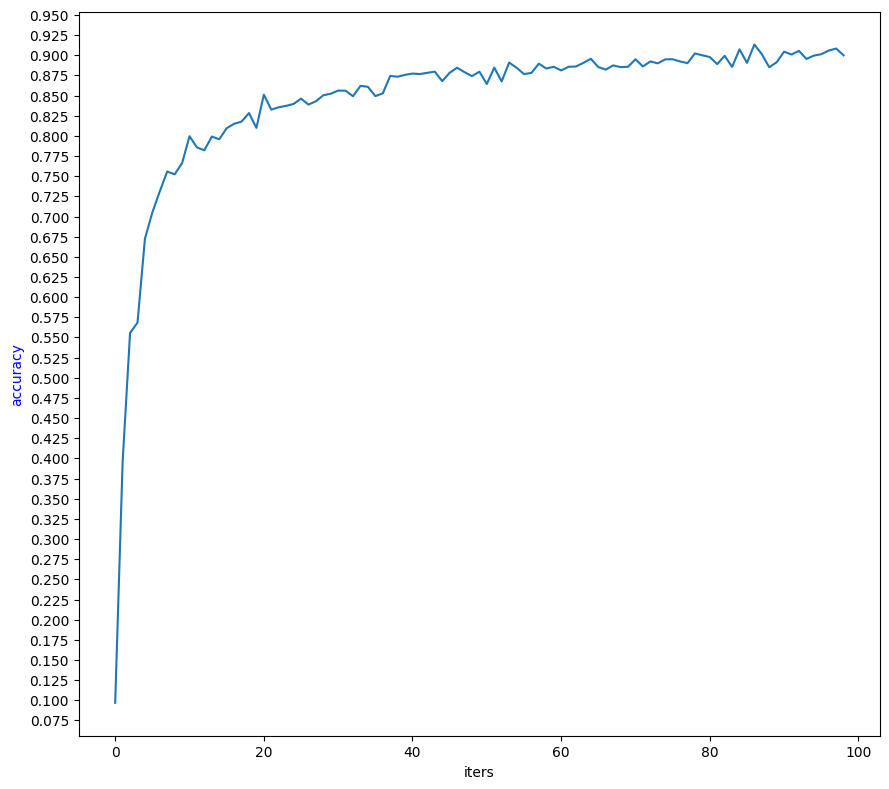

In [ ]:
test = ConvolutionalNeuralNetwork([('conv', [1, 5, 5, 3], 'relu'),     # 64x1x28x28 -> 64x3x24x24
                                   ('pool', [2, 2, 'max']),            # 64x3x24x24 -> 64x3x12x12
                                   ('flatten', []),                    # 64x3x12x12 -> 64x432
                                   ('full_conn', [432, [30, 20], 10,
                                                  'classification',
                                                  True, 'gd',
                                                  'leaky_relu'])       # 64x432 -> 64x10
                                   ])
test.cosmetic(progress_bar=False, loss_display=True, loss_graphic = True, iterations= 20)

test.train(train_batches, test_batches, 0.05, 3)